In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pytz  # Import pytz to handle time zone

# Section 1: Define Tickers and Time Range
tickers = ['MMM', 'ADBE', 'GOOGL', 'AMAT', 'AMZN']
end_date = datetime.now(pytz.timezone('America/New_York'))  # Make the datetime timezone-aware
start_date = end_date - timedelta(days=5 * 365)

# Section 2: Load Adjusted Close Prices from CSV
csv_path = '/Users/chrisgerlach/Programming/stock-market-pca/sp500_stock_data.csv'
all_data = pd.read_csv(csv_path)
all_data['Date'] = pd.to_datetime(all_data['Date'], utc=True, errors='coerce')

# Convert the 'Date' in DataFrame to the same timezone as 'start_date' and 'end_date'
all_data['Date'] = all_data['Date'].dt.tz_convert('America/New_York')

# Filter the data for the selected tickers and date range
adj_close_df = pd.DataFrame()
for ticker in tickers:
    data = all_data[(all_data['Ticker'] == ticker) & (all_data['Date'] >= start_date) & (all_data['Date'] <= end_date)]
    data.set_index('Date', inplace=True)
    adj_close_df[ticker] = data['Close']

# Deal with any NaN values by taking the average between day before and day after
for ticker in tickers:
    nan_rows = adj_close_df[ticker].index[adj_close_df[ticker].apply(np.isnan)]

    for nan_row in nan_rows:
        row_loc = adj_close_df.index.get_loc(nan_row)
        
        # Find values directly above and below the NaN value
        if row_loc > 0 and row_loc < len(adj_close_df) - 1:
            value_before = adj_close_df.iloc[row_loc - 1][ticker]
            value_after = adj_close_df.iloc[row_loc + 1][ticker]
            
            # Fill the NaN with the mean value
            mean_value = np.mean([value_before, value_after])
            adj_close_df.at[nan_row, ticker] = mean_value

# Save the adjusted close prices DataFrame to a CSV file
save_path = '/Users/chrisgerlach/Programming/stock-market-pca/adj_close_df.csv'
adj_close_df.to_csv(save_path)

Optimal Weights:
MMM: 0.0048
ADBE: 0.0085
GOOGL: 0.3250
AMAT: 0.6084
AMZN: 0.0533
Expected Annual Return: 0.2490
Expected Volatility: 0.3647
Sharpe Ratio: 0.6279


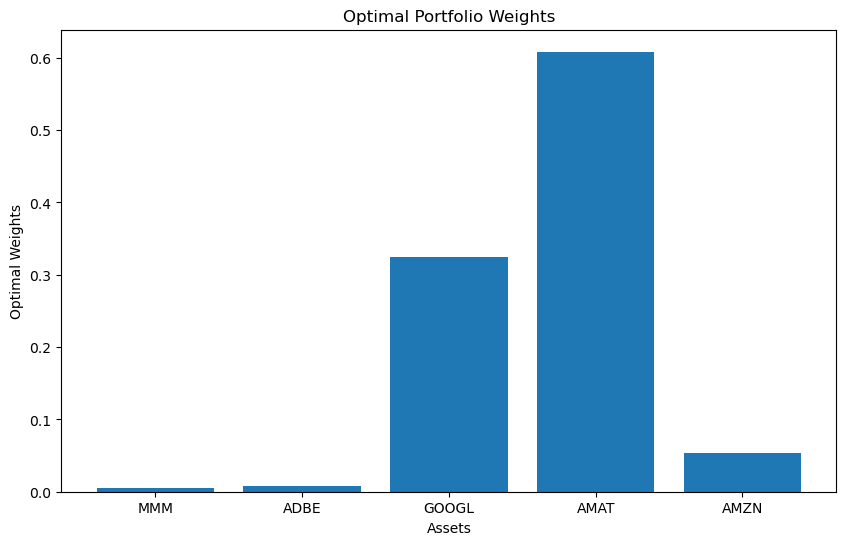

In [3]:
# Section 3: Calculate Lognormal Returns
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()

# Section 4: Calculate Covariance Matrix
cov_matrix = log_returns.cov() * 252

# Section 5: Define Portfolio Performance Metrics
def standard_deviation(weights, cov_matrix):
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

# Section 6: Portfolio Optimization using Monte Carlo Simulation
risk_free_rate = 0.02
num_portfolios = 100000
all_weights = np.zeros((num_portfolios, len(tickers)))
return_arr = np.zeros(num_portfolios)
volatility_arr = np.zeros(num_portfolios)
sharpe_arr = np.zeros(num_portfolios)

for i in range(num_portfolios):
    weights = np.array(np.random.random(len(tickers)))
    weights = weights / np.sum(weights)
    all_weights[i, :] = weights

    return_arr[i] = expected_return(weights, log_returns)
    volatility_arr[i] = standard_deviation(weights, cov_matrix)
    sharpe_arr[i] = sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

# Extract the portfolio that has the maximum Sharpe ratio
max_index = sharpe_arr.argmax()
optimal_weights = all_weights[max_index, :]

print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

optimal_portfolio_return = return_arr[max_index]
optimal_portfolio_volatility = volatility_arr[max_index]
optimal_sharpe_ratio = sharpe_arr[max_index]

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

# Display the Final Portfolio in a Plot
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
plt.show()